In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from astropy import constants as const
import math
from matplotlib.ticker import FormatStrFormatter
from scipy.special import wofz
import os
from IPython.display import clear_output

os.chdir(r"C:\Users\Krishna\Desktop\Python\UvA\masters_thesis")

In [2]:
def quadratic(coeffs, points):
#function: calculates the sum of weight of lightray points from the stars (= flux from the points) 
#inputs: coefficients of quadratic stellar profile, coordinates of interest from which lightrays are emerging
#outputs: distances of the lightray points from the center of star, flux from those lightrays
    r_list = np.ones(len(points))
    
    for index,item in enumerate(points):
        r_list[index] = np.sqrt((item[0]**2 + item[1]**2))/radius_of_star
 
    mu = np.sqrt(1-r_list**2)
    a1 = coeffs[0] * (1- mu)
    a2 = coeffs[1] * (1-mu)**2
    a3 = np.ones(len(points)) - a1 - a2
    
    return r_list*radius_of_star, a3



def gen_points(r_min, r_max, c_x, c_y, n_points):
    '''generates n-points in circle of specified radius centered at c_x, c_y  
    outputs: x-coordinates, y-coordinates of points generated   '''
    xy_min = [-1*r_max, -1*r_max]
    xy_max = [r_max, r_max]
    np.random.seed(7654321)

    data = np.random.uniform(low=xy_min, high=xy_max, size=(n_points,2))
    coord = []
    r_list = []

    for item in data:
        if (item[0]-c_x)**2 + (item[1]-c_y)**2 <= r_max**2 and (item[0]-c_x)**2 + (item[1]-c_y)**2 >= r_min**2:
            coord.append([item[0],item[1]])

    newcoord = np.array(coord)

    return np.array(newcoord) 

def voigt(del_nu,a,g):
    """Return the Voigt line shape at x with Lorentzian component HWHM 'g'
    and Gaussian component HWHM 'a'."""

    sigma = a / np.sqrt(2.0 * np.log(2.0))

    return np.real(wofz((del_nu + 1j*g)/sigma/np.sqrt(2.0))) / sigma/np.sqrt(2.0*np.pi)

def interp_profile(b_val, profile):
    '''function: find values of certain function (n3, velocity etc) for a particular altitude (or b in my code) based on their profile
    input: b_value = altitude, profile (velcoity, n_he, n3_he, h_ion_frac etc)
    output: y_val of profile at given altitude'''
    y_val = np.interp(b_val/radius_of_pl, altitude, profile) 
    
    return y_val

Transit depth: 0.98943216
Total luminosity of star: 34097.05027342236 units


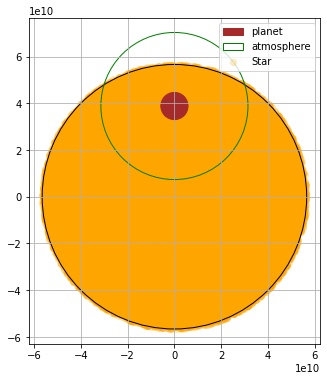

In [3]:
########################################################
num_wavelengths = 100
num_mc_rays = 50000
points_along_ray = 300
#########################

r_wasp69 = 0.813 * 6.96e+10 #centimeters
r_wasp69b = 0.1028*r_wasp69 #centimeters

radius_of_pl = r_wasp69b
radius_of_atm = 5.41*radius_of_pl
radius_of_star = r_wasp69

omega = 1.88002696e-5
transit_imp_parm = 0.686 * r_wasp69

star_coord = gen_points(0, radius_of_star, 0, 0, num_mc_rays)
stellar_model = 'quadratic'
coeff_quad = [0.27168999, 0.26061000]
coeffs = coeff_quad

print("Transit depth:", 1-(radius_of_pl/radius_of_star)**2)

r_list_star, weights = globals()[stellar_model](coeffs,star_coord)

tot_lum = np.sum(weights)
print("Total luminosity of star: {} units".format(tot_lum))


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

ax.scatter(star_coord[:,0],star_coord[:,1], color = 'orange', alpha = 0.2, label='Star')
circle1 = plt.Circle((0, 0), radius_of_star, color='black', fill=False)
ax.add_patch(circle1)
circle2 = plt.Circle((0, transit_imp_parm), radius_of_pl, color='brown', fill=True,label='planet')
ax.add_patch(circle2)
circle3 = plt.Circle((0, transit_imp_parm), radius_of_atm, color='green', fill=False,label='atmosphere')
ax.add_patch(circle3)
plt.grid()
plt.legend()
plt.show()

In [4]:
ech = 4.8032e-10
m_e = const.m_e.cgs.value
c = const.c.cgs.value
k_b = const.k_B.cgs.value
m_he = 6.6464731e-24 #grams
t_o = 5200.0

he_trip = np.array([10829.09114e-8,  10830.25010e-8,  10830.33977e-8])
nu = np.linspace(c/10828e-8,c/10832e-8, num_wavelengths)
wave = np.linspace(10828,10832,num_wavelengths)
f = np.array([5.9e-02, 1.7974e-01, 2.9958e-01]) #oscillator strengths

sigma_o = math.pi*ech*ech*f/(m_e*c)
alpha = np.sqrt(2*np.log(2)*k_b*t_o/m_he)*(1/he_trip)
gamma = 1.0216e7/(4*math.pi)

#############################################
cx = 0 #planet's center
cy = transit_imp_parm

starx = star_coord[:,0]
stary = star_coord[:,1]

indices_atm = np.where(((starx-cx)**2+(stary-cy)**2>radius_of_pl**2) & ((starx-cx)**2+(stary-cy)**2<=radius_of_atm**2))[0] #indices of lightray coordinates which are inside the planetary atmosphere
lightrays_in_atm = star_coord[indices_atm]-[cx,cy] #origin shift of coordinate system from star center to planetary center, so that b_values are distances from center of planet and not star's

indices_on_star = np.where( ( (starx-cx)**2+(stary-cy)**2)>radius_of_atm**2)[0]
lightrays_on_star = star_coord[indices_on_star]

weights_atm = weights[indices_atm]
weights_star = weights[indices_on_star]

print("Lightrays from star = ",len(star_coord))
print("Lightrays in atm = ",len(lightrays_in_atm))
print("Lightrays on star = ",len(lightrays_on_star))

print('Weights on star: ', np.sum(weights_star), len(weights_star))
print('Weights in atm: ', np.sum(weights_atm), len(weights_atm))
print('Total weights: ', np.sum(weights), len(weights))
print(np.sum(weights_star) + np.sum(weights_atm), len(weights_star)+len(weights_atm))

Lightrays from star =  39370
Lightrays in atm =  9201
Lightrays on star =  29708
Weights on star:  25608.865505221023 29708
Weights in atm:  8071.6715271369 9201
Total weights:  34097.05027342236 39370
33680.53703235793 38909


In [5]:
b_list_atm_rays = np.sqrt((lightrays_in_atm[:,0]**2+lightrays_in_atm[:,1]**2))

def spectrum_func(nu_i, outflow, rotation):
    
    '''function: for a given triplet index, gives the output flux array in the helium triplet wavelength range
    input: triplet index (0,1,2), Outflow and rotation conditions
    Outplut: Output flux array'''    
   
     #impact parameters (from planetary center) of the lightray coordinates
    final_output = 0

    for i in range(len(b_list_atm_rays)): #looping through all the lightrays to calculate output flux from each lightray
        
        b = b_list_atm_rays[i] #impact parm
        
        if rotation == True:
            rotation_vel = vel_at_phi[i]
        else: rotation_vel = 0
        
        alongray = np.linspace(b, radius_of_atm, points_along_ray)
        midpoints_alongray = (alongray[1:]+alongray[:-1])/2 #for numerical integration using midpoint rule        
        dx = np.diff(midpoints_alongray)[0]  #for numerical integration using midpoint rule        
        n3_r_val = interp_profile(midpoints_alongray, n_he * he_trip_frac) # gets n3 value at a values of 'x' (distance from planet center) which are along the light ray (from image 2) 

        if outflow == True:
            v_radial_b = interp_profile(midpoints_alongray, velocity)
        else: v_radial_b = 0
        
        theta = np.arccos(b/midpoints_alongray) #thetas values along the lightray for a particular lightray

        v_los1 = (rotation_vel*np.cos(theta)) - (v_radial_b * np.sin(theta))
        v_los2 = (rotation_vel*np.cos(theta)) + (v_radial_b * np.sin(theta))

        tau_b = 0; tau_b1 =0;  tau_b2 =0
        for triplet_index in range(3):
            linecenter1 = (c/he_trip[triplet_index])*(1+v_los1/c) #linecenter of spectral line from left half of the ray(array of 1000 elements)
            linecenter2 = (c/he_trip[triplet_index])*(1+v_los2/c) #(array of 1000 elements)

            del_nu1 = nu_i*np.ones(len(linecenter1)) - linecenter1         
            del_nu2 = nu_i*np.ones(len(linecenter1)) - linecenter2

            tau_b1 = np.sum(n3_r_val*sigma_o[triplet_index]*voigt(del_nu1,alpha[triplet_index],gamma)* dx *midpoints_alongray/(np.sqrt(midpoints_alongray**2-(b)**2)))
            tau_b2 = np.sum(n3_r_val*sigma_o[triplet_index]* voigt(del_nu2,alpha[triplet_index],gamma)*dx* midpoints_alongray/(np.sqrt(midpoints_alongray**2-(b)**2)))

            tau_b += tau_b1 + tau_b2

        flux_output = weights_atm[i] * np.exp(-1*tau_b) #weight of the lightray flux multipled with exp(-tau)
        final_output += flux_output #summing the flux from all the lightrays
 
    return final_output 

In [6]:
%%time
v_equator = omega * r_wasp69b
print("Rotation velocity at the Equator of the planet = {:.5f} km/sec".format(v_equator/1e5))

# angle made by the line joining center of planet to lightray with x-axis (from image 1)
# phi is used to categorize the lightray coordinate for implementing planet rotation velocity
# based on phi (which gives information on the latitde at which the lightray is coming from), I give certain rotation velocity for each latitude

vel_at_phi = omega*lightrays_in_atm[:,0] #np.ones(len(phi))



he_dens_file = np.genfromtxt("helium_profile_69_6900.0_50118723362.7_K6.txt")

altitude = he_dens_file[:,0]
density = he_dens_file[:,1]
velocity = he_dens_file[:,2]
h_ion_frac = he_dens_file[:,3]
n_all = he_dens_file[:,4]
n_e = he_dens_file[:,5]
n_he = he_dens_file[:,6]
he_sing_frac = he_dens_file[:,7]
he_trip_frac = he_dens_file[:,8]

#######################

flux_array1 = np.ones(len(nu)) * np.sum(weights_star)

for j in range(len(nu)):
    print(j, '/', len(nu))
    flux_array1[j] += spectrum_func(nu[j], outflow = True, rotation = True)
    clear_output(wait = True)

Wall time: 9min 11s


<Figure size 720x360 with 0 Axes>

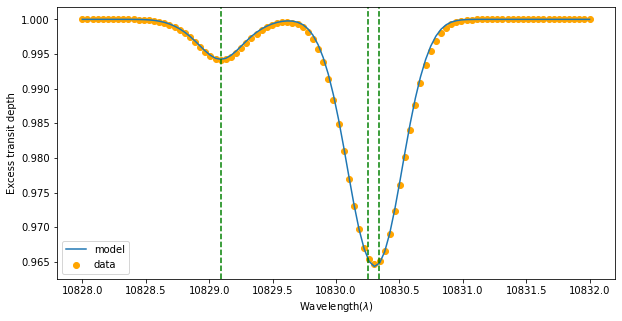

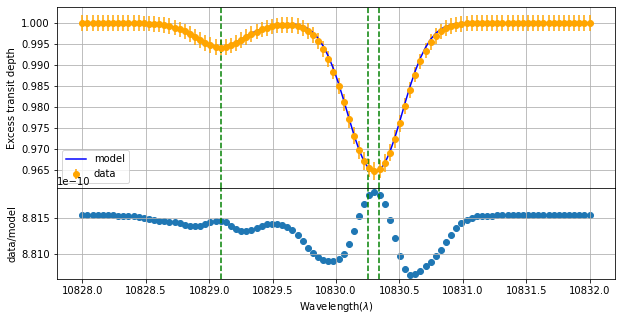

In [16]:
spectrum_file = np.genfromtxt("spectrum_69_10000_6900.0_50118723362.7_K6.txt")

fig = plt.figure(figsize=(10, 5))
lam = spectrum_file[:,0]

flux_vals = spectrum_file[:,1]
err_vals = spectrum_file[:,2]

norm_flux_spec = flux_vals/np.mean(flux_vals[:5])

fig = plt.figure(figsize=(10, 5))
plt.plot(wave,flux_array1/((np.sum(weights_star)+np.sum(weights_atm))),label='model')
plt.scatter(lam,norm_flux_spec,color='orange',label = "data")
plt.xlabel("Wavelength($\lambda$)")
plt.ylabel("Excess transit depth")
plt.axvline(x = 10829.09114, color = 'g', linestyle ='--')
plt.axvline(x = 10830.33977, color = 'g', linestyle ='--')
plt.axvline(x = 10830.25010, color = 'g', linestyle ='--')
plt.legend()
plt.show()


# fig = plt.figure(figsize=(10, 5))
# plt.plot(wave,flux_array1/(3*(np.sum(weights_star)+np.sum(weights_atm))),color = 'b',label = 'planet_rotation = {:.4f} km/sec and outflow present'.format(v_equator/1e5))
# #plt.plot(wave,norm_flux2,color = 'r',label = 'planet_rotation = 0 km/sec and outflow present')
# plt.xlabel("Wavelength($\lambda$)")
# plt.ylabel("Excess transit depth")
# plt.axvline(x = 10829.09114, color = 'g', linestyle ='--')
# plt.axvline(x = 10830.33977, color = 'g', linestyle ='--')
# plt.axvline(x = 10830.25010, color = 'g', linestyle ='--')
# # plt.legend()
# plt.show()


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5),sharex=True,gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0)

ax1.plot(wave,flux_array1/((np.sum(weights_star)+np.sum(weights_atm))),color='b',label = 'model')
ax1.errorbar(lam,norm_flux_spec,yerr = err_vals,color='orange',fmt='o',label = "data")
ax1.set_xlabel("Wavelength($\lambda$)")
ax1.set_ylabel("Excess transit depth")
ax1.axvline(x = 10829.09114, color = 'g', linestyle ='--')
ax1.axvline(x = 10830.33977, color = 'g', linestyle ='--')
ax1.axvline(x = 10830.25010, color = 'g', linestyle ='--')
ax1.grid()
ax2.scatter(lam, norm_flux_spec/flux_array1/((np.sum(weights_star)+np.sum(weights_atm))))
ax2.axvline(x = 10829.09114, color = 'g', linestyle ='--')
ax2.axvline(x = 10830.33977, color = 'g', linestyle ='--')
ax2.axvline(x = 10830.25010, color = 'g', linestyle ='--')
ax2.grid()
ax2.set_xlabel("Wavelength($\lambda$)")
ax2.set_ylabel("data/model")
# ax2.yaxis.set_major_formatter(FormatStrFormatter('%15F'))
ax1.legend()

plt.show()

In [8]:
import numpy as np

period = [300.55, 317.56]
errors = [10.14, 3.99]

u = 0
v = 0


for i in range(len(period)):
    
    mean = period[i]/errors[i]
    u+=mean
    
    er = 1/errors[i]
    v+=er
    
print('weighted mean = ', u/v)    
print("weighted error = ", 1/v)

weighted mean =  312.7567515923567
weighted error =  2.8633121019108283
